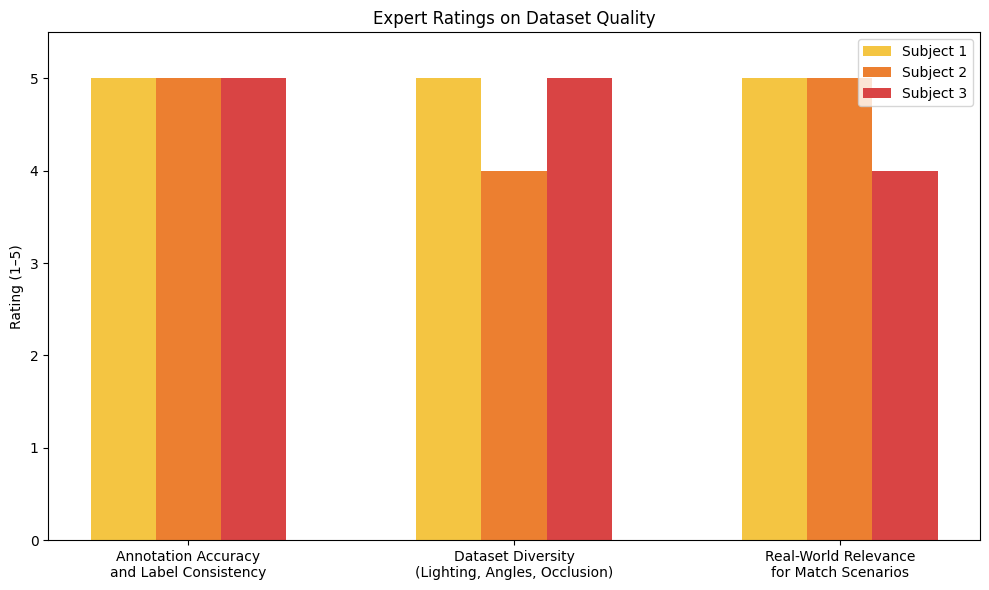

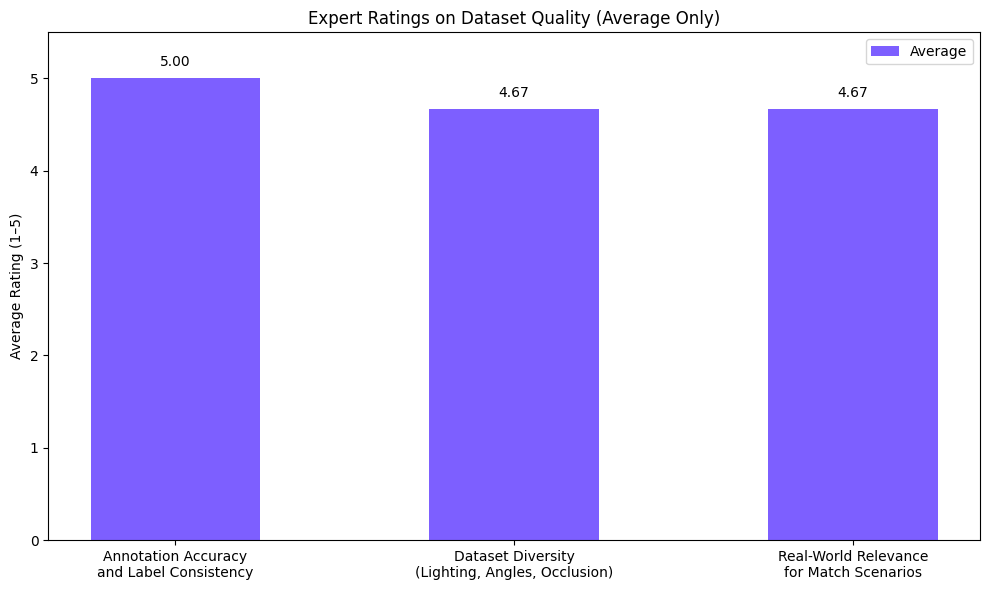

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Criteria and Ratings
criteria = [
    "Annotation Accuracy\nand Label Consistency",
    "Dataset Diversity\n(Lighting, Angles, Occlusion)",
    "Real-World Relevance\nfor Match Scenarios"
]

# Ratings by Subject
subject1 = [5, 5, 5]
subject2 = [5, 4, 5]
subject3 = [5, 5, 4]

x = np.arange(len(criteria))  # label locations
width = 0.2  # bar width

# Plot 1: Individual Ratings
fig1, ax1 = plt.subplots(figsize=(10, 6))

bars1 = ax1.bar(x - width, subject1, width, label='Subject 1', color='#f4c542')  # Yellow
bars2 = ax1.bar(x, subject2, width, label='Subject 2', color='#ec7f30')          # Orange
bars3 = ax1.bar(x + width, subject3, width, label='Subject 3', color='#d94444')  # Red

ax1.set_ylabel('Rating (1–5)')
ax1.set_title('Expert Ratings on Dataset Quality')
ax1.set_xticks(x)
ax1.set_xticklabels(criteria)
ax1.set_ylim(0, 5.5)

# Place legend inside top right
ax1.legend(loc='upper right', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()


# Plot 2: Averages Only
avg_ratings = [
    np.mean([subject1[i], subject2[i], subject3[i]])
    for i in range(len(criteria))
]

fig2, ax2 = plt.subplots(figsize=(10, 6))
bars_avg = ax2.bar(x, avg_ratings, width=0.5, color='#7d5fff', label='Average')  # Purple

# Add value labels on top of bars
for i, bar in enumerate(bars_avg):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{avg_ratings[i]:.2f}', ha='center', va='bottom')

ax2.set_ylabel('Average Rating (1–5)')
ax2.set_title('Expert Ratings on Dataset Quality (Average Only)')
ax2.set_xticks(x)
ax2.set_xticklabels(criteria)
ax2.set_ylim(0, 5.5)

# Legend for average
ax2.legend(loc='upper right', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()


In [1]:
import cv2
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns 
import clahe

# Load ResNet50 model for feature extraction
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50, preprocess_input

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

import tensorflow as tf

# from sklearn_relief import ReliefF 
from skrebate import ReliefF
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.ensemble import VotingClassifier

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

import pytesseract
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

/Users/nadunsenarathne/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
def load_yolo():
    path_to_cfg = "/Users/nadunsenarathne/Downloads/Documents/IIT/4th Year/FYP/CricXpert/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/yolo/yolov3.cfg" 
    path_to_weights = "/Users/nadunsenarathne/Downloads/Documents/IIT/4th Year/FYP/CricXpert/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/yolo/yolov3.weights"
    net = cv2.dnn.readNet(path_to_weights, path_to_cfg)
    layers_names = net.getLayerNames()
    
    # Handling different versions of OpenCV which may return different formats
    try:
        output_layers = [layers_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    except Exception:
        output_layers = [layers_names[i - 1] for i in net.getUnconnectedOutLayers()]

    return net, output_layers

def yolo_detect(net, image, output_layers, confidence_threshold=0.3):
    height, width, _ = image.shape
    blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    outputs = net.forward(output_layers)
    boxes = []
    confidences = []

    for output in outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > confidence_threshold and class_id == 0:  # Person class
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                if x >= 0 and y >= 0 and (x + w) <= width and (y + h) <= height:
                    boxes.append([x, y, w, h])
                    confidences.append(float(confidence))

    # Select the largest vertical box based on area if any boxes were detected
    if boxes:
        largest_box = max(boxes, key=lambda b: b[2] * b[3])  # b[2]*b[3] is the area of the box (w*h)
        largest_confidence = confidences[boxes.index(largest_box)]
        return [largest_box], [largest_confidence]
    return [], []  # Return empty lists if no boxes detected


In [5]:
# def extract_features(images):
#     # Load ResNet50 model
#     resnet_model = ResNet50(include_top=False, weights='imagenet', pooling='avg')
#     processed_images = []

#     for img in images:
#         if img is not None and img.size > 0:  # Ensure the image is not empty
#             resized_img = cv2.resize(img, (224, 224))
#             processed_images.append(resized_img)
    
#     if not processed_images:
#         return np.array([])  # Return empty array if no images to process
    
#     images_array = np.array(processed_images)
#     images_array = preprocess_input(images_array)
#     features = resnet_model.predict(images_array)
    
#     return features


In [3]:
import numpy as np
import cv2
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2



# ResNet50 model without the classification layer
def load_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    
    x = GlobalAveragePooling2D()(x)
    # x = Dense(256, activation='relu')(x)  # Adding L2 regularization
    # x = Dropout(0.3)(x)

    model = Model(inputs=base_model.input, outputs=x)
    return model

def extract_features(images, model):
    processed_images = []

    for img in images:
        if img is not None and img.size > 0:  # to ensure the image is not empty
            resized_img = cv2.resize(img, (224, 224))
            processed_images.append(resized_img)
    
    if not processed_images:
        return np.array([])  # return empty array if no images to process
    
    images_array = np.array(processed_images)
    images_array = preprocess_input(images_array)
    features = model.predict(images_array)
    
    return features

    # features = features.reshape((features.shape[0], -1))
    



In [4]:
# Create an instance of CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

def load_and_preprocess_data(root_folder, net, output_layers,model):
    images = []
    labels = []
    valid_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".tiff")
    
    for player_name in os.listdir(root_folder):
        player_folder = os.path.join(root_folder, player_name)
        if os.path.isdir(player_folder):
            for img_file in os.listdir(player_folder):
                if img_file.lower().endswith(valid_extensions):
                    img_path = os.path.join(player_folder, img_file)
                    img = cv2.imread(img_path)
                    if img is None or img.size == 0:
                        print(f"Failed to load image {img_path}.")
                        continue

                    boxes, _ = yolo_detect(net, img, output_layers)

                    for box in boxes:
                        x, y, w, h = box
                        if w > 0 and h > 0:  # Check if box dimensions are valid
                            cropped_img = img[y:y+h, x:x+w]

                            # # Apply CLAHE
                            # lab = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2LAB)
                            # l, a, b = cv2.split(lab)
                            # l = clahe.apply(l)
                            # processed_img = cv2.merge([l, a, b])
                            # processed_img = cv2.cvtColor(processed_img, cv2.COLOR_LAB2BGR)

                            if cropped_img.size > 0:  # Check if the cropped image is not empty
                                images.append(cropped_img)
                                labels.append(player_name)

    if not images:
        print("No valid images found in dataset.")
        return np.array([]), np.array([]), None  # Return empty arrays if no images
    
    # Extract features using the pre-trained model
    features = extract_features(images,model)
    
    if features.size == 0:
        print("No features extracted.")
        return np.array([]), np.array([]), None  # Return empty arrays if no features extracted
    
    encoder = LabelEncoder()
    encoded_labels = encoder.fit_transform(labels)
    
    return features, encoded_labels, encoder

In [5]:
def plot_learning_curves(model, X, y, title='Learning Curves'):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10), scoring='accuracy')

    # Calculate mean and standard deviation for training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Calculate mean and standard deviation for test set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_mean, 'o-', color="r",  label="Training score")
    plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")

    # Draw bands for standard deviation
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")

    plt.title(title)
    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy Score")
    plt.legend(loc="best")
    plt.show()

In [6]:
def plot_features(X_transformed, y, encoder, title):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=y, cmap='viridis', edgecolor='k', s=50)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.colorbar(scatter, ticks=range(len(encoder.classes_)), label='Classes')
    plt.clim(-0.5, len(encoder.classes_)-0.5)
    plt.grid(True)
    plt.show()

def visualize_with_pca(X, y, encoder, title='PCA Visualization'):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    plot_features(X_pca, y, encoder, title)

def visualize_with_tsne(X, y, encoder, title='t-SNE Visualization'):
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200, n_iter=300)
    X_tsne = tsne.fit_transform(X)
    plot_features(X_tsne, y, encoder, title)

# SVM

In [25]:
import plotly.express as px
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def visualize_with_pca_plotly(X, y, encoder, title='3D PCA Visualization'):
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X)
    plot_features_3d_plotly(X_pca, y, encoder, title)

def visualize_with_tsne_plotly(X, y, encoder, title='3D t-SNE Visualization'):
    tsne = TSNE(n_components=3, random_state=42, perplexity=30, n_iter=300)
    X_tsne = tsne.fit_transform(X)
    plot_features_3d_plotly(X_tsne, y, encoder, title)

def plot_features_3d_plotly(X_transformed, y, encoder, title):
    fig = px.scatter_3d(
        x=X_transformed[:, 0], y=X_transformed[:, 1], z=X_transformed[:, 2],
        color=encoder.inverse_transform(y),  # Use inverse_transform to get original labels
        labels={'color': 'Classes'},
        title=title
    )
    fig.update_traces(marker=dict(size=5, line=dict(width=2, color='DarkSlateGrey')))
    fig.update_layout(legend_title_text='Class')
    fig.show()

26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step


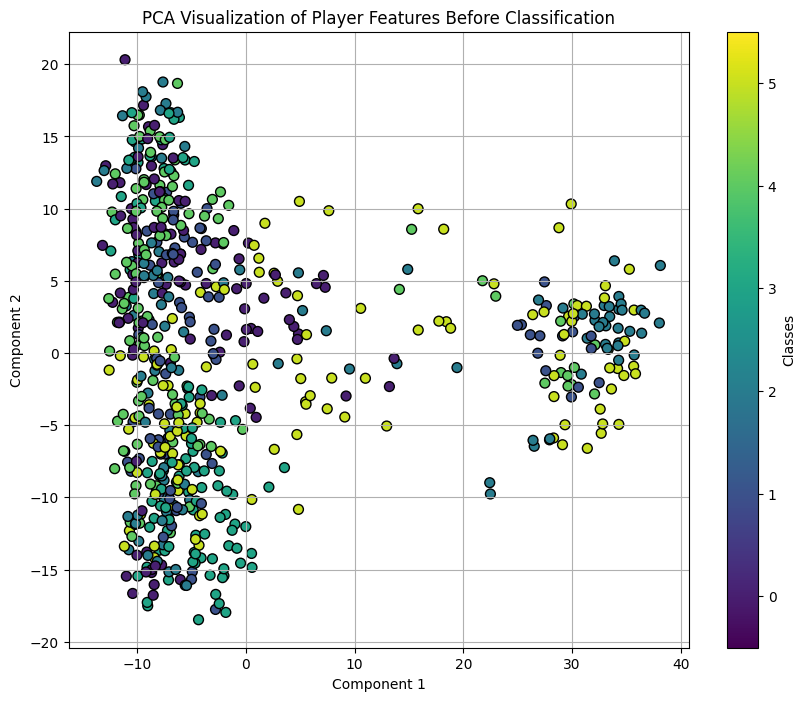

/Users/nadunsenarathne/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


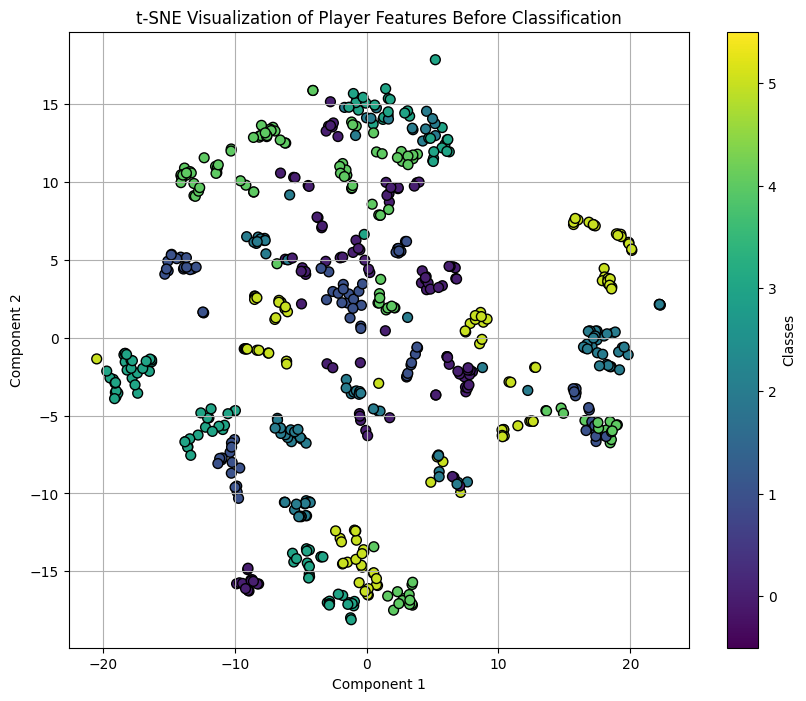

Training Accuracy: 0.9675425038639877
Testing Accuracy: 0.9320987654320988


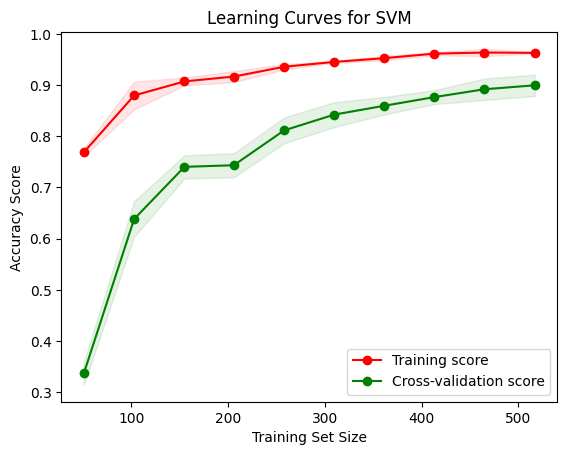

Classification Report:
                 precision    recall  f1-score   support

 Arshdeep_Singh       0.94      1.00      0.97        29
     Axar_Patel       0.89      0.89      0.89        19
 Jasprit_Bumrah       1.00      0.82      0.90        28
  Kuldeep_Yadav       0.87      1.00      0.93        33
Ravindra_Jadeja       0.96      0.85      0.90        26
    Virat_Kohli       0.96      1.00      0.98        27

       accuracy                           0.93       162
      macro avg       0.94      0.93      0.93       162
   weighted avg       0.94      0.93      0.93       162



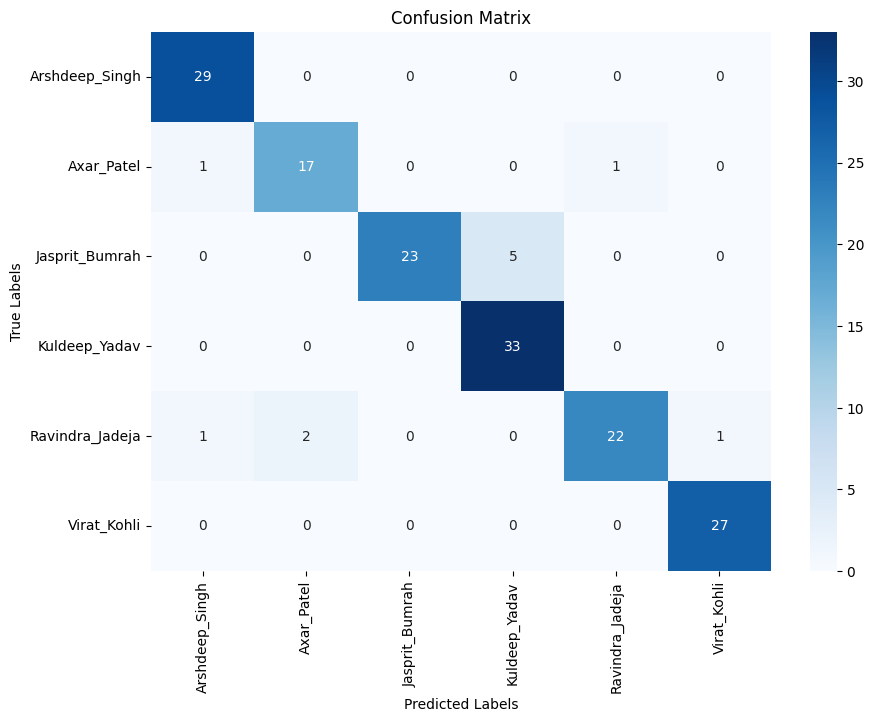

In [28]:
def main():
    # Load YOLO model for detection
    net, output_layers = load_yolo()

    # Load the ResNet model for feature extraction
    model = load_model()
    
    output_frame_folder = '/Users/nadunsenarathne/Downloads/Documents/IIT/4th Year/FYP/CricXpert/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/extracted_frames'
    

    # Load and preprocess data, passing the model for feature extraction
    X, y, encoder = load_and_preprocess_data(output_frame_folder, net, output_layers,model)

    # Split data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # print('X_train : ',X_train)
    # print(X_train.shape)
    # print('\n y_train : ',y_train)
    # print(y_train.shape)

    # Visualization before classification
    visualize_with_pca(X_train, y_train, encoder, 'PCA Visualization of Player Features Before Classification')
    visualize_with_tsne(X_train, y_train, encoder, 't-SNE Visualization of Player Features Before Classification')

    # # Visualize training data in 3D using PCA
    # visualize_with_pca_plotly(X_train, y_train, encoder, 'Interactive 3D PCA Visualization of Training Data')
    # # Visualize training data in 3D using t-SNE
    # visualize_with_tsne_plotly(X_train, y_train, encoder, 'Interactive 3D t-SNE Visualization of Training Data')

    # Train SVM
    svm_classifier = SVC(C= 1, gamma= 'scale', kernel= 'rbf', probability=True)
    svm_classifier.fit(X_train, y_train)

    # Evaluate the classifier
    train_accuracy = svm_classifier.score(X_train, y_train)
    test_accuracy = svm_classifier.score(X_test, y_test)
    print(f"Training Accuracy: {train_accuracy}")
    print(f"Testing Accuracy: {test_accuracy}")

    # Plotting the learning curves for the ensemble model
    plot_learning_curves(svm_classifier, X_train, y_train, title='Learning Curves for SVM')

    # Generate classification report
    y_pred = svm_classifier.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=encoder.classes_)
    print("Classification Report:")
    print(report)

    # Generate and plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Save the SVM model and label encoder
    # joblib.dump(svm_classifier, 'svm_player_recognition.pkl')
    # joblib.dump(encoder, 'svm_label_encoder.pkl')

if __name__ == "__main__":
    main()

##### with learning curve and cross validation

26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 651ms/step
Training Accuracy: 1.0
Testing Accuracy: 0.9337349397590361
Cross-validation scores: [0.80120482 0.87878788 0.87878788 0.84848485 0.82424242]
Mean cross-validation score: 0.8463015699160277


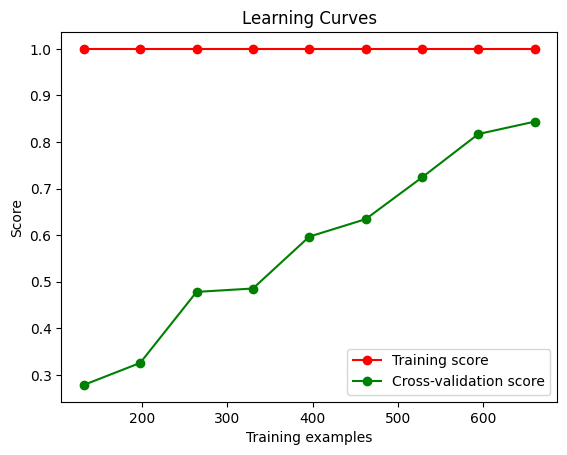

Classification Report:
                 precision    recall  f1-score   support

 Arshdeep_Singh       0.88      0.97      0.92        30
     Axar_Patel       0.93      0.89      0.91        28
 Jasprit_Bumrah       0.96      0.90      0.93        30
  Kuldeep_Yadav       0.97      0.97      0.97        31
Ravindra_Jadeja       0.91      0.88      0.89        24
    Virat_Kohli       0.96      1.00      0.98        23

       accuracy                           0.93       166
      macro avg       0.93      0.93      0.93       166
   weighted avg       0.93      0.93      0.93       166



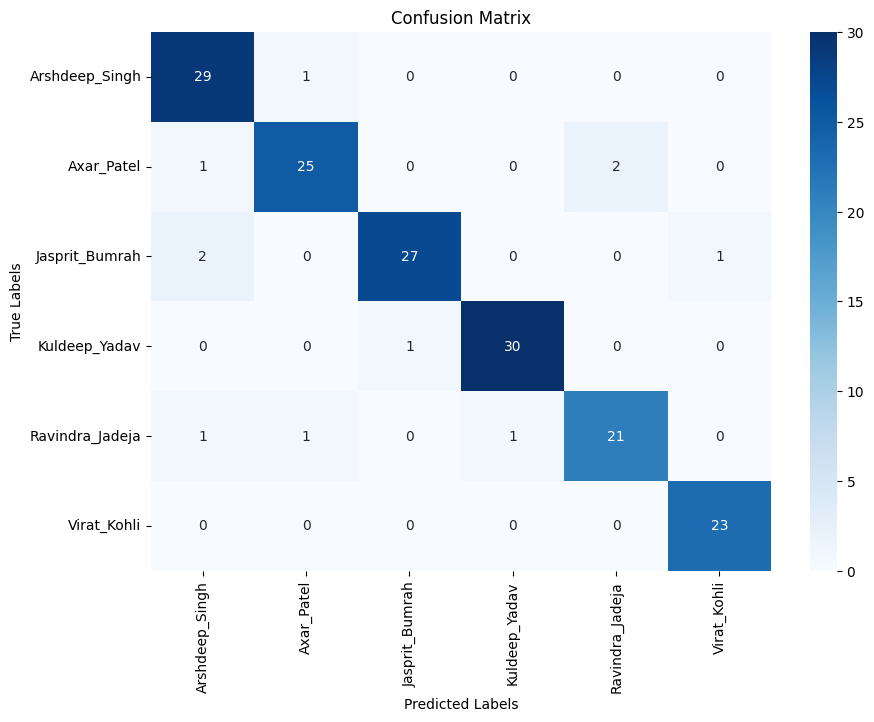

In [63]:
# import joblib
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
# from sklearn.svm import SVC
# from sklearn.metrics import classification_report, confusion_matrix
# from sklearn.preprocessing import LabelEncoder
# import numpy as np

# def main():
#     # Load YOLO model for detection
#     net, output_layers = load_yolo()

#     # Load the ResNet model for feature extraction
#     model = load_model()
    
#     output_frame_folder = '/Users/pubudusenarathne/Downloads/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/extracted_frames'
    
#     # Load and preprocess data, passing the model for feature extraction
#     X, y, encoder = load_and_preprocess_data(output_frame_folder, net, output_layers, model)

#     # Split data into training and testing
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#     # Train SVM
#     svm_classifier = SVC(kernel='linear', probability=True)
#     svm_classifier.fit(X_train, y_train)

#     # Evaluate the classifier
#     train_accuracy = svm_classifier.score(X_train, y_train)
#     test_accuracy = svm_classifier.score(X_test, y_test)
#     print(f"Training Accuracy: {train_accuracy}")
#     print(f"Testing Accuracy: {test_accuracy}")

#     # Cross-validation
#     cv_scores = cross_val_score(svm_classifier, X, y, cv=5)
#     print("Cross-validation scores:", cv_scores)
#     print("Mean cross-validation score:", cv_scores.mean())

#     # Learning Curves
#     train_sizes, train_scores, test_scores = learning_curve(
#         svm_classifier, X, y, cv=5, n_jobs=-1, 
#         train_sizes=np.linspace(.1, 1.0, 10))
    
#     plot_learning_curves(train_sizes, train_scores, test_scores)

#     # Generate classification report
#     y_pred = svm_classifier.predict(X_test)
#     report = classification_report(y_test, y_pred, target_names=encoder.classes_)
#     print("Classification Report:")
#     print(report)

#     # Generate and plot confusion matrix
#     cm = confusion_matrix(y_test, y_pred)
#     plt.figure(figsize=(10, 7))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
#     plt.xlabel('Predicted Labels')
#     plt.ylabel('True Labels')
#     plt.title('Confusion Matrix')
#     plt.show()

#     # Save the SVM model and label encoder
#     joblib.dump(svm_classifier, 'svm_player_recognition.pkl')
#     joblib.dump(encoder, 'svm_label_encoder.pkl')

# def plot_learning_curves(train_sizes, train_scores, test_scores):
#     train_scores_mean = np.mean(train_scores, axis=1)
#     test_scores_mean = np.mean(test_scores, axis=1)

#     plt.figure()
#     plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
#     plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

#     plt.title("Learning Curves")
#     plt.xlabel("Training examples")
#     plt.ylabel("Score")
#     plt.legend(loc="best")
#     plt.show()

# if __name__ == "__main__":
#     main()


##### with learning curve and hyperparameter tuning

26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 665ms/step
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score: 0.95
Training Accuracy: 1.0
Testing Accuracy: 0.9939759036144579


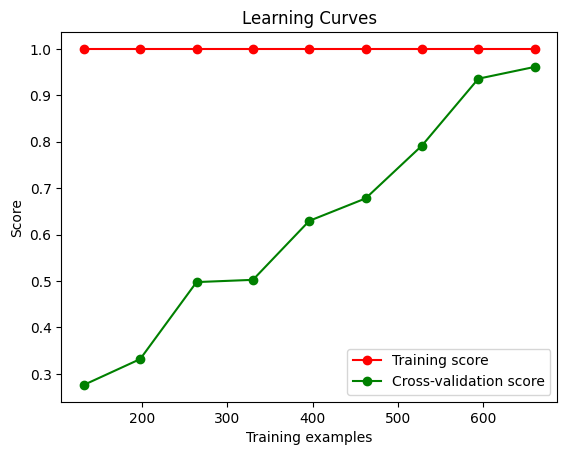

Classification Report:
                 precision    recall  f1-score   support

 Arshdeep_Singh       0.97      1.00      0.98        30
     Axar_Patel       1.00      1.00      1.00        28
 Jasprit_Bumrah       1.00      0.97      0.98        30
  Kuldeep_Yadav       1.00      1.00      1.00        31
Ravindra_Jadeja       1.00      1.00      1.00        24
    Virat_Kohli       1.00      1.00      1.00        23

       accuracy                           0.99       166
      macro avg       0.99      0.99      0.99       166
   weighted avg       0.99      0.99      0.99       166



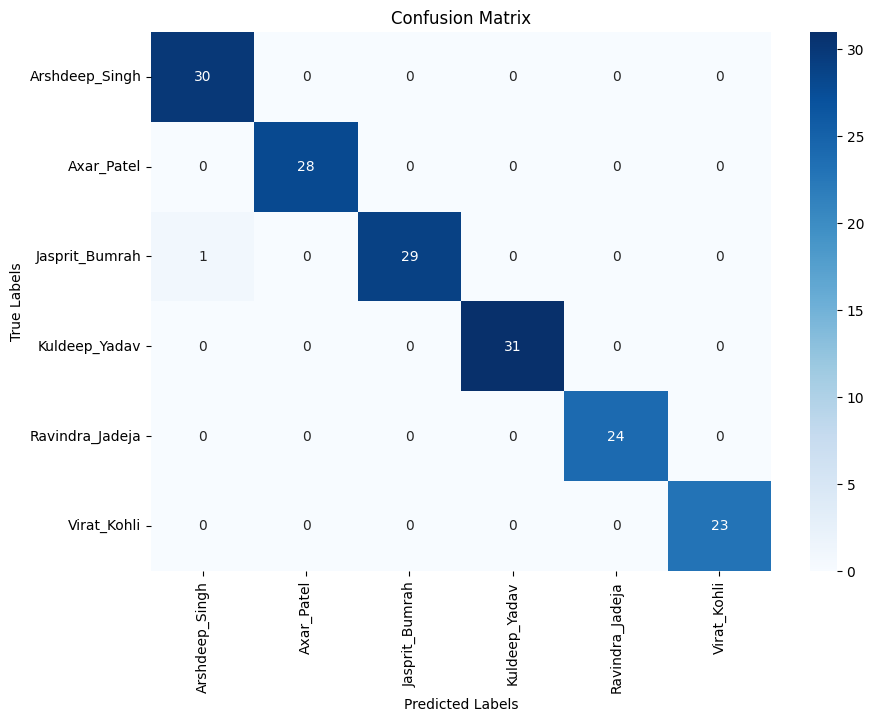

In [67]:
# import joblib
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV
# from sklearn.svm import SVC
# from sklearn.metrics import classification_report, confusion_matrix
# from sklearn.preprocessing import LabelEncoder
# import numpy as np

# def main():
#     # Load YOLO model for detection
#     net, output_layers = load_yolo()

#     # Load the ResNet model for feature extraction
#     model = load_model()
    
#     output_frame_folder = '/Users/pubudusenarathne/Downloads/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/extracted_frames'
    
#     # Load and preprocess data, passing the model for feature extraction
#     X, y, encoder = load_and_preprocess_data(output_frame_folder, net, output_layers, model)

#     # Split data into training and testing
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#     # Set up the parameter grid
#     param_grid = {
#         'C': [0.1, 1, 10, 100],  # Regularization parameter
#         'kernel': ['linear', 'rbf'],  # Type of kernel
#         'gamma': ['scale', 'auto']  # Kernel coefficient
#     }

#     # Create an SVC classifier object
#     svm = SVC(probability=True)

#     # Create a GridSearchCV object
#     grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', verbose=1)

#     # Fit the grid search to the data
#     grid_search.fit(X_train, y_train)

#     # Print out the best parameters and best score
#     print("Best parameters:", grid_search.best_params_)
#     print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

#     # Retrieve the best model from the grid search
#     best_svm = grid_search.best_estimator_
    
#     # Evaluate the best model on the training set
#     training_accuracy = best_svm.score(X_train, y_train)
#     print(f"Training Accuracy: {training_accuracy}")

#     # Evaluate the best model on the test set
#     test_accuracy = best_svm.score(X_test, y_test)
#     print(f"Testing Accuracy: {test_accuracy}")

#     # Learning Curves
#     train_sizes, train_scores, test_scores = learning_curve(
#         best_svm, X, y, cv=5, n_jobs=-1, 
#         train_sizes=np.linspace(.1, 1.0, 10))
    
#     plot_learning_curves(train_sizes, train_scores, test_scores)

#     # Generate classification report
#     y_pred = best_svm.predict(X_test)
#     report = classification_report(y_test, y_pred, target_names=encoder.classes_)
#     print("Classification Report:")
#     print(report)

#     # Generate and plot confusion matrix
#     cm = confusion_matrix(y_test, y_pred)
#     plt.figure(figsize=(10, 7))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
#     plt.xlabel('Predicted Labels')
#     plt.ylabel('True Labels')
#     plt.title('Confusion Matrix')
#     plt.show()

#     # Save the best SVM model and label encoder
#     joblib.dump(best_svm, 'best_svm_player_recognition.pkl')
#     joblib.dump(encoder, 'svm_label_encoder.pkl')

# def plot_learning_curves(train_sizes, train_scores, test_scores):
#     train_scores_mean = np.mean(train_scores, axis=1)
#     test_scores_mean = np.mean(test_scores, axis=1)

#     plt.figure()
#     plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
#     plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

#     plt.title("Learning Curves")
#     plt.xlabel("Training examples")
#     plt.ylabel("Score")
#     plt.legend(loc="best")
#     plt.show()

# if __name__ == "__main__":
#     main()


# KNN

26/26 ━━━━━━━━━━━━━━━━━━━━ 26s 976ms/step


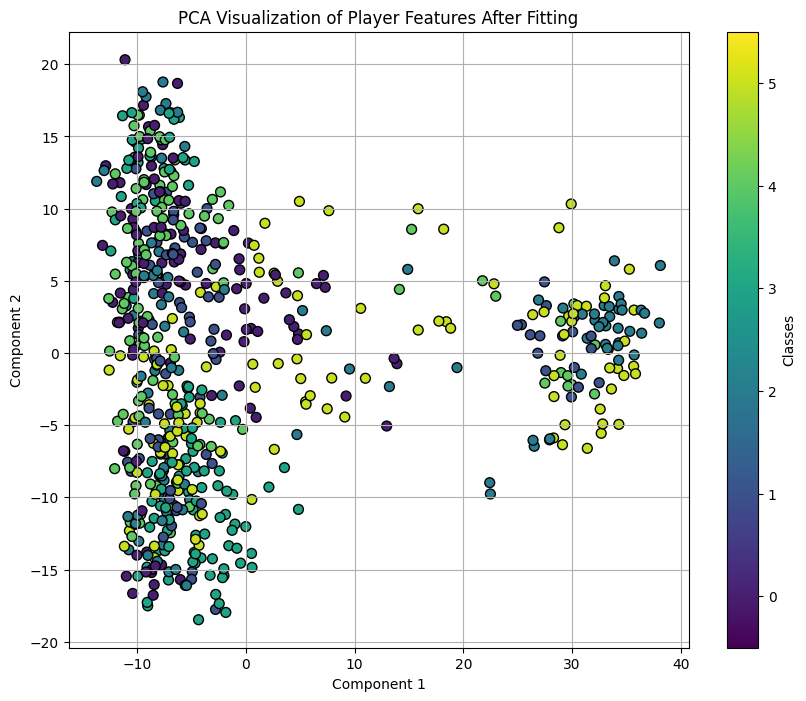

/Users/nadunsenarathne/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


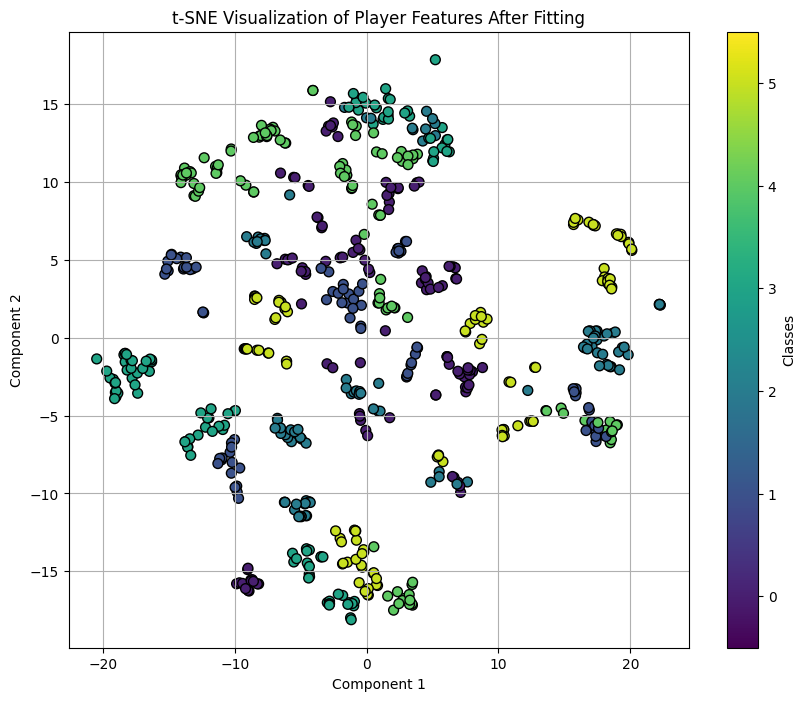

Training Accuracy: 0.9721792890262752
Testing Accuracy: 0.9814814814814815


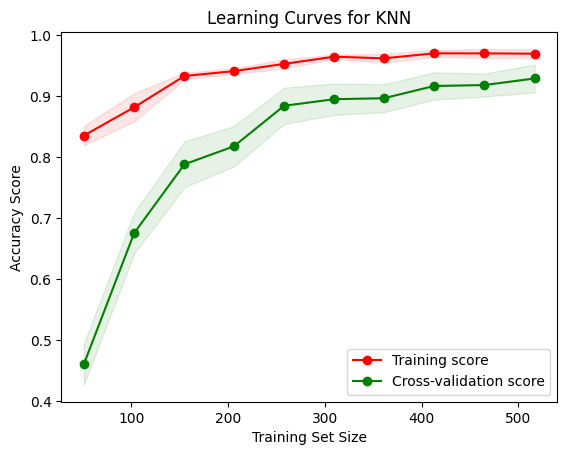

Classification Report:
                 precision    recall  f1-score   support

 Arshdeep_Singh       0.97      0.97      0.97        29
     Axar_Patel       0.95      0.95      0.95        19
 Jasprit_Bumrah       1.00      1.00      1.00        28
  Kuldeep_Yadav       1.00      1.00      1.00        33
Ravindra_Jadeja       1.00      0.96      0.98        26
    Virat_Kohli       0.96      1.00      0.98        27

       accuracy                           0.98       162
      macro avg       0.98      0.98      0.98       162
   weighted avg       0.98      0.98      0.98       162



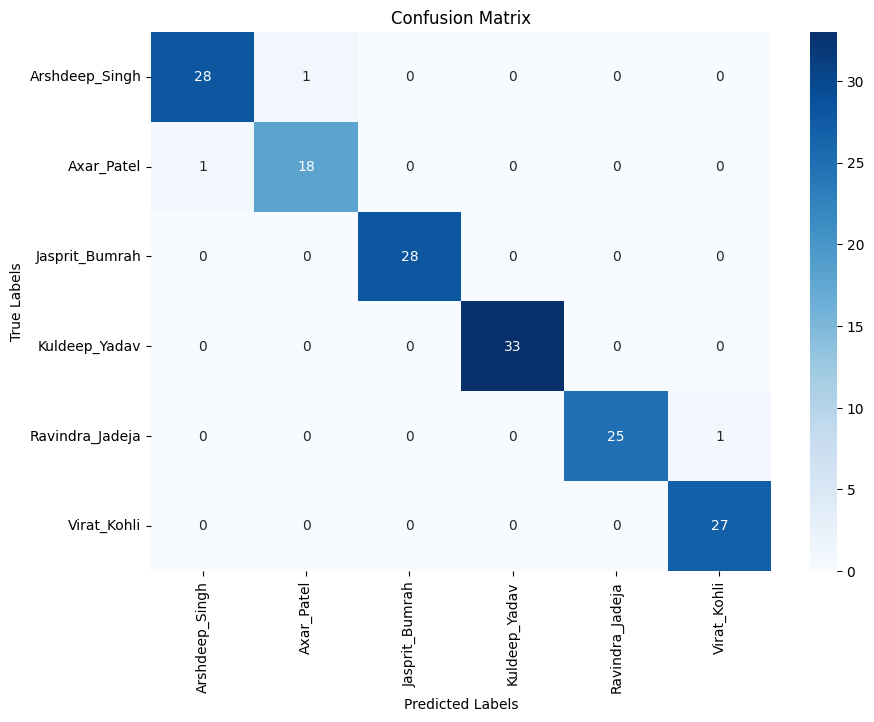

In [29]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

def main():
    # Load YOLO model for detection
    net, output_layers = load_yolo()

    # Load the ResNet model for feature extraction
    model = load_model()
    
    output_frame_folder = '/Users/nadunsenarathne/Downloads/Documents/IIT/4th Year/FYP/CricXpert/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/extracted_frames'
    
    # Load and preprocess data, now passing the model for feature extraction
    X, y, encoder = load_and_preprocess_data(output_frame_folder, net, output_layers, model)

    # Split data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train KNN
    knn_classifier = KNeighborsClassifier(n_neighbors=3,metric= 'manhattan', weights= 'uniform')
    knn_classifier.fit(X_train, y_train)

    # Make predictions on the training data
    y_pred_train = knn_classifier.predict(X_train)
    # Visualization after fitting
    visualize_with_pca(X_train, y_pred_train, encoder, 'PCA Visualization of Player Features After Fitting')
    visualize_with_tsne(X_train, y_pred_train, encoder, 't-SNE Visualization of Player Features After Fitting')

    # Evaluate the classifier
    train_accuracy = knn_classifier.score(X_train, y_train)
    test_accuracy = knn_classifier.score(X_test, y_test)
    print(f"Training Accuracy: {train_accuracy}")
    print(f"Testing Accuracy: {test_accuracy}")

    # Plotting the learning curves for the ensemble model
    plot_learning_curves(knn_classifier, X_train, y_train, title='Learning Curves for KNN')

    # Generate classification report
    y_pred = knn_classifier.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=encoder.classes_)
    print("Classification Report:")
    print(report)

    # Generate and plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Save the KNN model and label encoder
    # joblib.dump(knn_classifier, 'knn_player_recognition.pkl')
    # joblib.dump(encoder, 'knn_label_encoder.pkl')


if __name__ == "__main__":
    main()


##### with learning curve and cross validation

In [57]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.metrics import classification_report, confusion_matrix
# from sklearn.preprocessing import LabelEncoder
# import joblib

# def main():
#     # Load YOLO model for detection
#     net, output_layers = load_yolo()

#     # Load the ResNet model for feature extraction
#     model = load_model()
    
#     output_frame_folder = '/Users/pubudusenarathne/Downloads/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/extracted_frames'
    
#     # Load and preprocess data, now passing the model for feature extraction
#     X, y, encoder = load_and_preprocess_data(output_frame_folder, net, output_layers, model)

#     # Split data into training and testing
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#     # Train KNN
#     knn_classifier = KNeighborsClassifier(n_neighbors=5)
#     knn_classifier.fit(X_train, y_train)

#     # Evaluate the classifier
#     train_accuracy = knn_classifier.score(X_train, y_train)
#     test_accuracy = knn_classifier.score(X_test, y_test)
#     print(f"Training Accuracy: {train_accuracy}")
#     print(f"Testing Accuracy: {test_accuracy}")

#     # Cross-validation
#     cv_scores = cross_val_score(knn_classifier, X, y, cv=5)
#     print("Cross-validation scores:", cv_scores)
#     print("Mean cross-validation score:", cv_scores.mean())

#     # Learning Curves
#     train_sizes, train_scores, test_scores = learning_curve(
#         knn_classifier, X, y, cv=5, n_jobs=-1, 
#         train_sizes=np.linspace(.1, 1.0, 10))
    
#     plot_learning_curves(train_sizes, train_scores, test_scores)

#     # Generate classification report
#     y_pred = knn_classifier.predict(X_test)
#     report = classification_report(y_test, y_pred, target_names=encoder.classes_)
#     print("Classification Report:")
#     print(report)

#     # Generate and plot confusion matrix
#     cm = confusion_matrix(y_test, y_pred)
#     plt.figure(figsize=(10, 7))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
#     plt.xlabel('Predicted Labels')
#     plt.ylabel('True Labels')
#     plt.title('Confusion Matrix')
#     plt.show()

#     # Save the KNN model and label encoder
#     joblib.dump(knn_classifier, 'knn_player_recognition.pkl')
#     joblib.dump(encoder, 'knn_label_encoder.pkl')

# def plot_learning_curves(train_sizes, train_scores, test_scores):
#     train_scores_mean = np.mean(train_scores, axis=1)
#     test_scores_mean = np.mean(test_scores, axis=1)

#     plt.figure()
#     plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
#     plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

#     plt.title("Learning Curves")
#     plt.xlabel("Training examples")
#     plt.ylabel("Score")
#     plt.legend(loc="best")
#     plt.show()

# if __name__ == "__main__":
#     main()


KeyboardInterrupt: 

##### with learning curve and hyperparameter tuning

26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 683ms/step
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best parameters: {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}
Best cross-validation score: 0.94
Training Accuracy: 1.0
Testing Accuracy: 0.9698795180722891


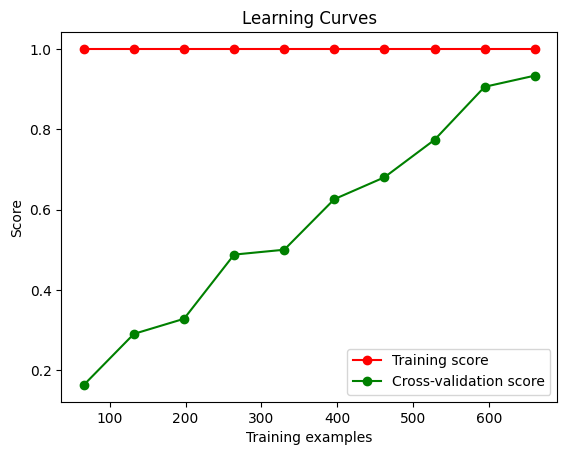

Classification Report:
                 precision    recall  f1-score   support

 Arshdeep_Singh       0.91      0.97      0.94        30
     Axar_Patel       1.00      1.00      1.00        28
 Jasprit_Bumrah       1.00      0.90      0.95        30
  Kuldeep_Yadav       0.97      1.00      0.98        31
Ravindra_Jadeja       0.96      0.96      0.96        24
    Virat_Kohli       1.00      1.00      1.00        23

       accuracy                           0.97       166
      macro avg       0.97      0.97      0.97       166
   weighted avg       0.97      0.97      0.97       166



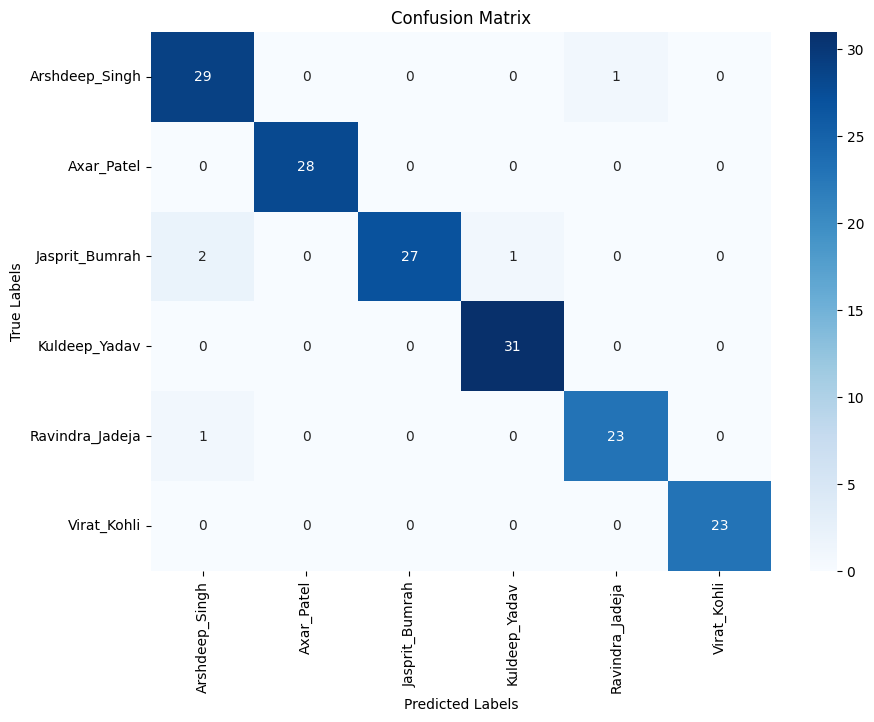

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.metrics import classification_report, confusion_matrix
# from sklearn.preprocessing import LabelEncoder
# import joblib

# def main():
#     # Load YOLO model for detection
#     net, output_layers = load_yolo()

#     # Load the ResNet model for feature extraction
#     model = load_model()
    
#     output_frame_folder = '/Users/pubudusenarathne/Downloads/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/extracted_frames'
    
#     # Load and preprocess data, now passing the model for feature extraction
#     X, y, encoder = load_and_preprocess_data(output_frame_folder, net, output_layers, model)

#     # Split data into training and testing
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#     # Set up the parameter grid
#     param_grid = {
#         'n_neighbors': range(1, 31, 2),
#         'weights': ['uniform', 'distance'],
#         'metric': ['euclidean', 'manhattan']
#     }

#     # Create a KNeighbors classifier object
#     knn = KNeighborsClassifier()

#     # Create a GridSearchCV object
#     grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', verbose=1)

#     # Fit the grid search to the data
#     grid_search.fit(X_train, y_train)

#     # Print out the best parameters and best score
#     print("Best parameters:", grid_search.best_params_)
#     print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

#     # Retrieve the best model from the grid search
#     best_knn = grid_search.best_estimator_
    
#     # Evaluate the best model on the training set
#     training_accuracy = best_knn.score(X_train, y_train)
#     print(f"Training Accuracy: {training_accuracy}")

#     # Evaluate the best model on the test set
#     test_accuracy = best_knn.score(X_test, y_test)
#     print(f"Testing Accuracy: {test_accuracy}")

#     # Learning Curves
#     train_sizes, train_scores, test_scores = learning_curve(
#         best_knn, X, y, cv=5, n_jobs=-1, 
#         train_sizes=np.linspace(.1, 1.0, 10))
    
#     plot_learning_curves(train_sizes, train_scores, test_scores)

#     # Generate classification report
#     y_pred = best_knn.predict(X_test)
#     report = classification_report(y_test, y_pred, target_names=encoder.classes_)
#     print("Classification Report:")
#     print(report)

#     # Generate and plot confusion matrix
#     cm = confusion_matrix(y_test, y_pred)
#     plt.figure(figsize=(10, 7))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
#     plt.xlabel('Predicted Labels')
#     plt.ylabel('True Labels')
#     plt.title('Confusion Matrix')
#     plt.show()

#     # # Save the best KNN model and label encoder
#     # joblib.dump(best_knn, 'best_knn_player_recognition.pkl')
#     # joblib.dump(encoder, 'label_encoder.pkl')

# def plot_learning_curves(train_sizes, train_scores, test_scores):
#     train_scores_mean = np.mean(train_scores, axis=1)
#     test_scores_mean = np.mean(test_scores, axis=1)

#     plt.figure()
#     plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
#     plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

#     plt.title("Learning Curves")
#     plt.xlabel("Training examples")
#     plt.ylabel("Score")
#     plt.legend(loc="best")
#     plt.show()

# if __name__ == "__main__":
#     main()


## Stacking

26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step
Training Accuracy: 0.9845440494590417
Testing Accuracy: 0.9814814814814815


/Users/nadunsenarathne/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/nadunsenarathne/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/nadunsenarathne/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/nadunsenarathne/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/nadunsenarathne/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least

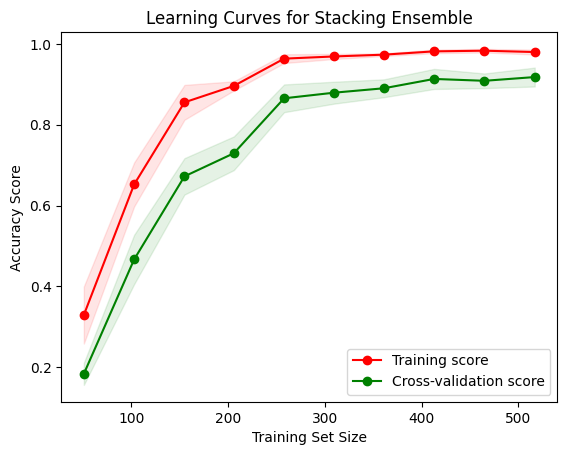

Classification Report:
                 precision    recall  f1-score   support

 Arshdeep_Singh       0.97      1.00      0.98        29
     Axar_Patel       1.00      0.89      0.94        19
 Jasprit_Bumrah       1.00      1.00      1.00        28
  Kuldeep_Yadav       1.00      1.00      1.00        33
Ravindra_Jadeja       0.96      0.96      0.96        26
    Virat_Kohli       0.96      1.00      0.98        27

       accuracy                           0.98       162
      macro avg       0.98      0.98      0.98       162
   weighted avg       0.98      0.98      0.98       162



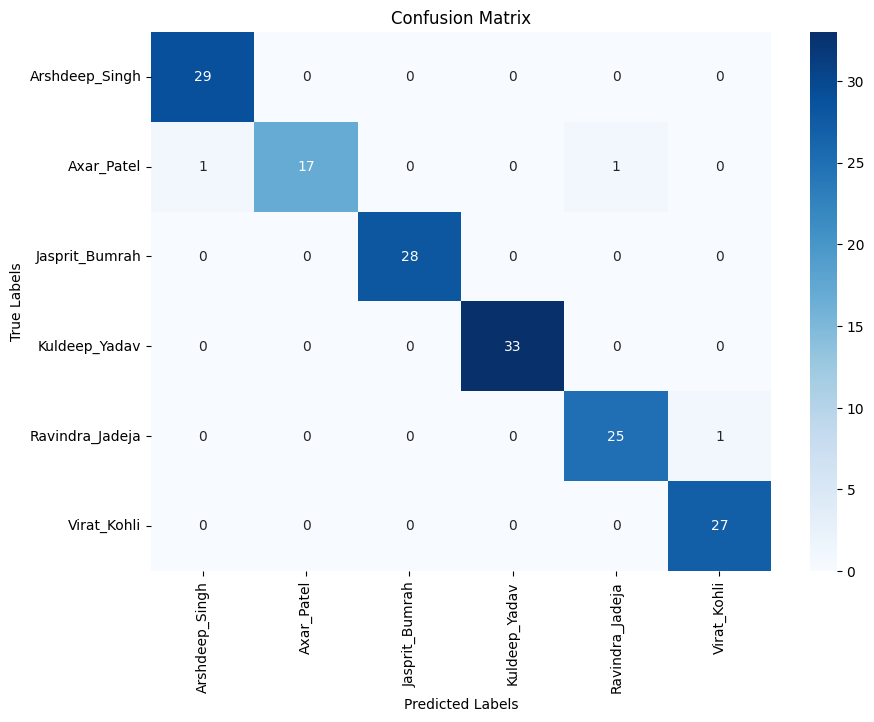

In [9]:
def main():
    # Load YOLO model for detection
    net, output_layers = load_yolo()

    # Load the ResNet model for feature extraction
    model = load_model()

    output_frame_folder = '/Users/nadunsenarathne/Downloads/Documents/IIT/4th Year/FYP/CricXpert/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/resnet_data'

    # Load and preprocess data, passing the model for feature extraction
    X, y, encoder = load_and_preprocess_data(output_frame_folder, net, output_layers, model)

    # # Feature selection with ReliefF
    # fs = ReliefF(n_neighbors=5, n_features_to_select=1000)  # Adjust parameters as needed
    # X = fs.fit_transform(X, y)

    # Split data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    

    # Define the base models
    estimators = [
        ('svm', SVC(kernel='rbf', C=1, gamma='scale', probability=True)),
        ('knn', KNeighborsClassifier(n_neighbors=3, metric='manhattan', weights='uniform'))
    ]

    # rf = RandomForestClassifier(n_estimators=100)
    # knn = KNeighborsClassifier(n_neighbors=5, metric='manhattan', weights='uniform')
    log_reg_meta = LogisticRegression(C=0.001, penalty='l2', solver='liblinear')

    # Define the stacking ensemble
    stack = StackingClassifier(estimators=estimators, final_estimator=log_reg_meta)
    stack.fit(X_train, y_train)

    # Make predictions on the training data to see how the model classified the training set
    y_pred_train = stack.predict(X_train)


    # Visualization after fitting
    # visualize_with_pca(X_train, y_pred_train, encoder, 'PCA Visualization of Player Features After Fitting')
    # visualize_with_tsne(X_train, y_pred_train, encoder, 't-SNE Visualization of Player Features After Fitting')


    # Evaluate the classifier
    train_accuracy = stack.score(X_train, y_train)
    test_accuracy = stack.score(X_test, y_test)
    print(f"Training Accuracy: {train_accuracy}")
    print(f"Testing Accuracy: {test_accuracy}")

    # Plotting the learning curves for the ensemble model
    plot_learning_curves(stack, X_train, y_train, title='Learning Curves for Stacking Ensemble')

    # Generate classification report
    y_pred = stack.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=encoder.classes_)
    print("Classification Report:")
    print(report)

    # Generate and plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Save the best ensemble model and label encoder
    joblib.dump(stack, 'ensemble_player_recognition.pkl')
    joblib.dump(encoder, 'ensemble_label_encoder.pkl')

if __name__ == "__main__":
    main()


## Voting Classifier

26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 682ms/step
Training Accuracy: 0.9681818181818181
Testing Accuracy: 0.9578313253012049


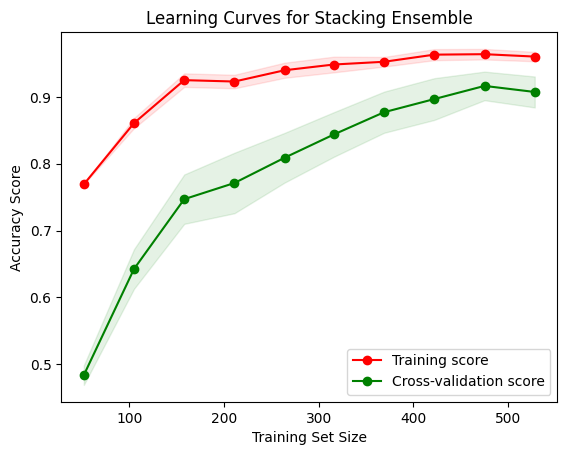

Classification Report:
                 precision    recall  f1-score   support

 Arshdeep_Singh       0.83      1.00      0.91        30
     Axar_Patel       1.00      0.96      0.98        28
 Jasprit_Bumrah       1.00      0.87      0.93        30
  Kuldeep_Yadav       0.97      1.00      0.98        31
Ravindra_Jadeja       1.00      0.92      0.96        24
    Virat_Kohli       1.00      1.00      1.00        23

       accuracy                           0.96       166
      macro avg       0.97      0.96      0.96       166
   weighted avg       0.96      0.96      0.96       166



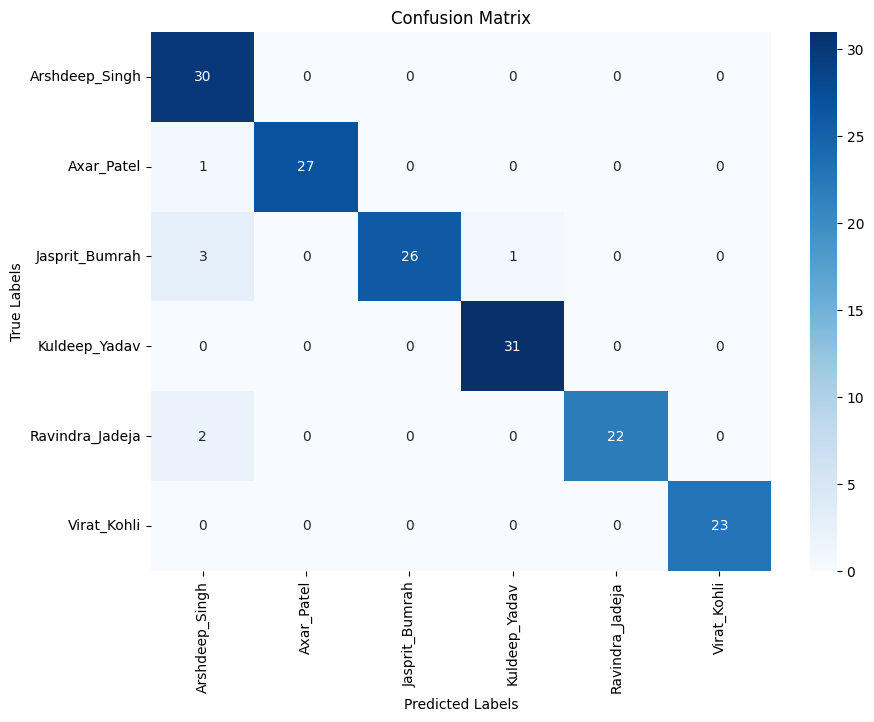

In [59]:
def main():
    # Load YOLO model for detection
    net, output_layers = load_yolo()

    # Load the ResNet model for feature extraction
    model = load_model()

    output_frame_folder = '/Users/pubudusenarathne/Downloads/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/extracted_frames'

    # Load and preprocess data, passing the model for feature extraction
    X, y, encoder = load_and_preprocess_data(output_frame_folder, net, output_layers, model)

    # Split data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define the base models
    estimators = [
        ('svm', SVC(kernel='rbf', C=1, gamma='scale', probability=True)),
        ('knn', KNeighborsClassifier(n_neighbors=3, metric='manhattan', weights='uniform'))
    ]

    # rf = RandomForestClassifier(n_estimators=100)
    # knn = KNeighborsClassifier(n_neighbors=5, metric='manhattan', weights='uniform')
    # log_reg_meta = LogisticRegression(C=0.001, penalty='l2', solver='liblinear')

    # # Define the stacking ensemble
    # stack = StackingClassifier(estimators=estimators, final_estimator=log_reg_meta)
    # stack.fit(X_train, y_train)

    # Define the voting ensemble
    voting_clf = VotingClassifier(estimators=estimators, voting='hard')
    voting_clf.fit(X_train, y_train)

    # Evaluate the classifier
    train_accuracy = voting_clf.score(X_train, y_train)
    test_accuracy = voting_clf.score(X_test, y_test)
    print(f"Training Accuracy: {train_accuracy}")
    print(f"Testing Accuracy: {test_accuracy}")

    # Plotting the learning curves for the ensemble model
    plot_learning_curves(voting_clf, X_train, y_train, title='Learning Curves for Stacking Ensemble')

    # Generate classification report
    y_pred = voting_clf.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=encoder.classes_)
    print("Classification Report:")
    print(report)

    # Generate and plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Save the best ensemble model and label encoder
    joblib.dump(voting_clf, 'ensemble_player_recognition.pkl')
    joblib.dump(encoder, 'ensemble_label_encoder.pkl')

if __name__ == "__main__":
    main()


## Decision Level Fusion

26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 669ms/step
Training Accuracy: 0.9681818181818183
Testing Accuracy: 0.9578313253012049
Classification Report:
                 precision    recall  f1-score   support

 Arshdeep_Singh       1.00      1.00      1.00        30
     Axar_Patel       1.00      1.00      1.00        28
 Jasprit_Bumrah       1.00      1.00      1.00        30
  Kuldeep_Yadav       1.00      1.00      1.00        31
Ravindra_Jadeja       1.00      0.96      0.98        24
    Virat_Kohli       0.96      1.00      0.98        23

       accuracy                           0.99       166
      macro avg       0.99      0.99      0.99       166
   weighted avg       0.99      0.99      0.99       166



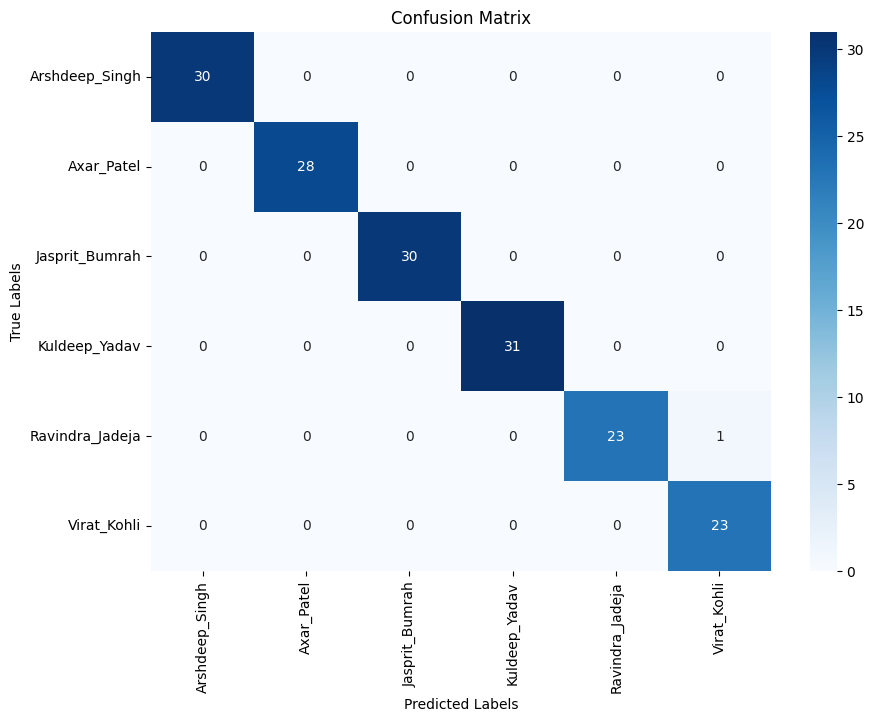

In [60]:
def decision_level_fusion(prob1, prob2):
    """Simple average fusion of probability estimates."""
    return (prob1 + prob2) / 2

def main():
    # Load YOLO model for detection
    net, output_layers = load_yolo()

    # Load the ResNet model for feature extraction
    model = load_model()

    output_frame_folder = '/Users/pubudusenarathne/Downloads/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/extracted_frames'

    # Load and preprocess data, passing the model for feature extraction
    X, y, encoder = load_and_preprocess_data(output_frame_folder, net, output_layers, model)

    # Split data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    svm = SVC(kernel='rbf', C=1, gamma='scale', probability=True)
    knn = KNeighborsClassifier(n_neighbors=3, metric='manhattan', weights='uniform')

    svm.fit(X_train, y_train)
    knn.fit(X_train, y_train)

    # Get probability predictions
    prob_svm = svm.predict_proba(X_test)
    prob_knn = knn.predict_proba(X_test)

    # Fuse predictions
    fused_prob = decision_level_fusion(prob_svm, prob_knn)
    y_pred = np.argmax(fused_prob, axis=1)  # Convert probabilities to final class prediction

    train_accuracy = (svm.score(X_train, y_train) + knn.score(X_train, y_train)) / 2
    test_accuracy = (svm.score(X_test, y_test) + knn.score(X_test, y_test)) / 2
    print(f"Training Accuracy: {train_accuracy}")
    print(f"Testing Accuracy: {test_accuracy}")

    report = classification_report(y_test, y_pred, target_names=encoder.classes_)
    print("Classification Report:")
    print(report)

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # joblib.dump(svm, 'svm_model.pkl')
    # joblib.dump(knn, 'knn_model.pkl')
    # joblib.dump(encoder, 'label_encoder.pkl')

if __name__ == "__main__":
    main()

## Inference with full integration

In [5]:
# path to tesseract 
pytesseract.pytesseract.tesseract_cmd = ('/opt/homebrew/bin/tesseract') 

# player database with both full reference name and jersey name
player_database = {
    "Virat_Kohli": {"name": "VIRAT", "number": "18"},
    "Arshdeep_Singh": {"name": "ARSHDEEP", "number": "2"},
    "Axar_Patel": {"name": "AXAR", "number": "20"},
    "Jasprit_Bumrah": {"name": "JASPRIT", "number": "93"},
    "Kuldeep_Yadav": {"name": "KULDEEP", "number": "23"},
    "Ravindra_Jadeja": {"name": "JADEJA", "number": "8"}
}

In [6]:
def process_frame_for_OCR_text_detection(image):

    # Convert image to RGB for consistent display if originally in BGR
    if image.shape[2] == 3:  # assuming the image has 3 channels
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Original dimensions
    (H, W) = image.shape[:2]

    # Set the new width and height to nearest multiple of 32 for EAST model
    newW = int(W / 32) * 32
    newH = int(H / 32) * 32

    # Resize the image to fit model requirements
    image = cv2.resize(image, (newW, newH))

    # Load the pre-trained EAST text detector model
    model_path = '/Users/nadunsenarathne/Downloads/Documents/IIT/4th Year/FYP/CricXpert/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/saved_models/ResNet/frozen_east_text_detection.pb'
    net = cv2.dnn.readNet(model_path)

    # Prepare the image for the model
    blob = cv2.dnn.blobFromImage(image, 1.0, (newW, newH),
                                 (123.68, 116.78, 103.94), swapRB=True, crop=False)
    net.setInput(blob)

    # Layer names for the output layers
    layerNames = [
        "feature_fusion/Conv_7/Sigmoid",
        "feature_fusion/concat_3"
    ]

    # Forward pass of the model to get output
    (scores, geometry) = net.forward(layerNames)

    # Decode the predictions
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    # Loop over the number of rows
    for y in range(0, numRows):
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        # Loop over the number of columns
        for x in range(0, numCols):
            if scoresData[x] < 0.5:
                continue

            offsetX = x * 4.0
            offsetY = y * 4.0
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    # Apply non-maxima suppression to avoid overlaps
    indices = cv2.dnn.NMSBoxes(rects, confidences, 0.5, 0.4)

    # # Plot the figures side by side
    # plt.figure(figsize=(18, 12))


    # # Plot original detections
    # plt.subplot(1, 3, 1)
    # plt.imshow(image)
    # for i in indices.flatten():
    #     (startX, startY, endX, endY) = rects[i]
    #     rect = plt.Rectangle((startX, startY), endX - startX, endY - startY, edgecolor='r', facecolor='none')
    #     plt.gca().add_patch(rect)
    # plt.title('Original Detections')
    # plt.axis('off')


    # # Plot original detections
    # plt.subplot(1, 3, 1)
    # plt.imshow(image)

    if len(indices) > 0:
        indices = indices.flatten()  # Ensuring flattening is possible

        # # Plotting and processing detections
        # plt.figure(figsize=(10, 6))

        # for i in indices.flatten():
            # (startX, startY, endX, endY) = rects[i]
            # rect = plt.Rectangle((startX, startY), endX - startX, endY - startY, edgecolor='r', facecolor='none')
            # plt.gca().add_patch(rect)
    # plt.title('Original Detections')
    # plt.axis('off')

    # # Plot merged box
    # plt.subplot(1, 3, 2)
    # plt.imshow(image)

    cropped_img = None

    if len(indices) > 0:
        min_x = max(0, min([rects[i][0] for i in indices]) - 20)
        min_y = max(0, min([rects[i][1] for i in indices]) - 20)
        max_x = min(W, max([rects[i][2] for i in indices]) + 20)
        max_y = min(H, max([rects[i][3] for i in indices]) + 20)

        cropped_img = image[min_y:max_y, min_x:max_x]

        # merged_rect = plt.Rectangle((min_x, min_y), max_x - min_x, max_y - min_y, edgecolor='r', facecolor='none')
        # plt.gca().add_patch(merged_rect)
        # plt.title('Merged Detections with Expanded Box')
    else:
        print('No Detections Found')
    # plt.axis('off')

    # # Display the cropped area from the merged box
    # plt.subplot(1, 3, 3)
    # if len(indices) > 0:
    #     plt.imshow(cropped_img)
    #     plt.title('Cropped Area from Merged Box')
    # else:
    #     plt.title('No Area to Crop')
    # plt.axis('off')

    # plt.show()


    # Initialize 'text' to an empty string
    text = ''

    # Proceed with text recognition on the cropped image
    if cropped_img is not None:
        # Convert cropped image from RGB to BGR for OpenCV operations
        cropped_img_bgr = cv2.cvtColor(cropped_img, cv2.COLOR_RGB2BGR)
        
        # Convert to grayscale
        gray = cv2.cvtColor(cropped_img_bgr, cv2.COLOR_BGR2GRAY)

        # # Apply thresholding
        # _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)

        # Use median blur to remove noise
        blur = cv2.medianBlur(gray, 5)

        # # Resize for better accuracy
        # resized_img = cv2.resize(blur, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

        # Configure parameters for Tesseract
        custom_config = r'--oem 3 --psm 11'
        text = pytesseract.image_to_string(blur, config=custom_config)

        # # plotting the preprocessing visualization of the cropped image
        # plt.figure(figsize=(12, 10))
        # plt.subplot(1, 3, 1)
        # plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))
        # plt.title('Grayscale')

        # plt.subplot(1, 3, 2)
        # plt.imshow(blur, cmap='gray')
        # plt.title('Median Blur')

        # plt.subplot(1, 3, 3)
        # plt.imshow(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))
        # plt.title('Resized for OCR')

        # plt.show()

        print("Detected text:", text)
    else:
        print("No area was cropped for text recognition.")

    return text


In [7]:
import cv2 as cv
import os
import numpy as np
import tensorflow as tf
from mtcnn.mtcnn import MTCNN
from keras_facenet import FaceNet
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
import cv2
import numpy as np
import os
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing import image
import joblib
from collections import Counter
from mtcnn.mtcnn import MTCNN
from keras_facenet import FaceNet
import mediapipe as mp
from tensorflow.keras.models import load_model

# Load the FaceNet model for embeddings
embedder = FaceNet()

# Initialize MediaPipe Pose Estimation
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

# Function to get embeddings using FaceNet
def get_embedding(face_img):
    face_img = face_img.astype('float32')
    face_img = np.expand_dims(face_img, axis=0)
    return embedder.embeddings(face_img)[0]

# Function to extract pose landmarks from the cropped image
def extract_pose_landmarks(cropped_img):
    # Convert the image to RGB
    image_rgb = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
    
    # Perform pose detection
    results = pose.process(image_rgb)

    # If landmarks are detected
    if results.pose_landmarks:
        landmarks = []
        for landmark in results.pose_landmarks.landmark:
            landmarks.append([landmark.x, landmark.y, landmark.z])
        return np.array(landmarks).flatten()
    return None

# Calculate step length between left and right ankles
def calculate_step_length(pose_sequence):
    left_ankle_x, left_ankle_y = pose_sequence[27*3], pose_sequence[27*3 + 1]  # left ankle
    right_ankle_x, right_ankle_y = pose_sequence[28*3], pose_sequence[28*3 + 1]  # right ankle
    step_length = np.linalg.norm(np.array([right_ankle_x, right_ankle_y]) - np.array([left_ankle_x, left_ankle_y]))
    return step_length

# Calculate joint velocities between two consecutive frames
def calculate_velocity(pose_sequence_t, pose_sequence_t1, joint_index):
    joint_t = np.array([pose_sequence_t[joint_index*3], pose_sequence_t[joint_index*3 + 1]])
    joint_t1 = np.array([pose_sequence_t1[joint_index*3], pose_sequence_t1[joint_index*3 + 1]])
    velocity = np.linalg.norm(joint_t1 - joint_t)
    return velocity

# Calculate joint angles (hip-knee-ankle)
def calculate_joint_angle(pose_sequence, hip_idx, knee_idx, ankle_idx):
    hip = np.array([pose_sequence[hip_idx*3], pose_sequence[hip_idx*3 + 1]])
    knee = np.array([pose_sequence[knee_idx*3], pose_sequence[knee_idx*3 + 1]])
    ankle = np.array([pose_sequence[ankle_idx*3], pose_sequence[ankle_idx*3 + 1]])
    
    # Calculate vectors
    vec_hip_knee = knee - hip
    vec_knee_ankle = ankle - knee
    
    # Calculate the cosine of the angle between the vectors
    cos_angle = np.dot(vec_hip_knee, vec_knee_ankle) / (np.linalg.norm(vec_hip_knee) * np.linalg.norm(vec_knee_ankle))
    angle = np.arccos(cos_angle)
    return np.degrees(angle)

# Calculate joint accelerations between two consecutive frames (acceleration is the change in velocity)
def calculate_acceleration(velocity_t, velocity_t1):
    acceleration = velocity_t1 - velocity_t
    return acceleration

# Calculate angular velocity (rate of change of joint angles between consecutive frames)
def calculate_angular_velocity(joint_angle_t, joint_angle_t1):
    angular_velocity = joint_angle_t1 - joint_angle_t
    return angular_velocity

# Calculate hip displacement between two frames
def calculate_hip_displacement(pose_sequence_t, pose_sequence_t1):
    left_hip_t = np.array([pose_sequence_t[23*3], pose_sequence_t[23*3 + 1]])
    right_hip_t = np.array([pose_sequence_t[24*3], pose_sequence_t[24*3 + 1]])
    left_hip_t1 = np.array([pose_sequence_t1[23*3], pose_sequence_t1[23*3 + 1]])
    right_hip_t1 = np.array([pose_sequence_t1[24*3], pose_sequence_t1[24*3 + 1]])
    
    # Calculate hip centers
    hip_center_t = (left_hip_t + right_hip_t) / 2
    hip_center_t1 = (left_hip_t1 + right_hip_t1) / 2
    
    # Displacement between frames
    hip_displacement = np.linalg.norm(hip_center_t1 - hip_center_t)
    return hip_displacement


# Temporal feature extraction (step length, joint velocities, joint angles, etc.)
def calculate_features(pose_landmarks, previous_landmarks=None, previous_velocities=None, previous_angles=None):
    frame_features = [0] * 10  # Ten features (step length, velocity x2, joint angles x2, acceleration x2, angular velocity x2, hip displacement)

    # Step Length
    step_length = calculate_step_length(pose_landmarks)
    frame_features[0] = step_length

    # Joint Velocities
    if previous_landmarks is not None:
        left_ankle_velocity = calculate_velocity(previous_landmarks, pose_landmarks, 27)
        right_ankle_velocity = calculate_velocity(previous_landmarks, pose_landmarks, 28)
        frame_features[1] = left_ankle_velocity
        frame_features[2] = right_ankle_velocity

        # Joint Accelerations
        if previous_velocities is not None:
            left_ankle_acceleration = calculate_acceleration(previous_velocities[0], left_ankle_velocity)
            right_ankle_acceleration = calculate_acceleration(previous_velocities[1], right_ankle_velocity)
            frame_features[5] = left_ankle_acceleration
            frame_features[6] = right_ankle_acceleration

        # Hip Displacement (New Feature)
        hip_displacement = calculate_hip_displacement(previous_landmarks, pose_landmarks)
        frame_features[9] = hip_displacement
    else:
        frame_features[1] = frame_features[2] = 0  # Velocities
        frame_features[5] = frame_features[6] = 0  # Accelerations
        frame_features[9] = 0  # Hip Displacement

    # Joint Angles
    left_leg_angle = calculate_joint_angle(pose_landmarks, 23, 25, 27)
    right_leg_angle = calculate_joint_angle(pose_landmarks, 24, 26, 28)
    frame_features[3] = left_leg_angle
    frame_features[4] = right_leg_angle

    # Angular Velocities
    if previous_angles is not None:
        left_leg_angular_velocity = calculate_angular_velocity(previous_angles[0], left_leg_angle)
        right_leg_angular_velocity = calculate_angular_velocity(previous_angles[1], right_leg_angle)
        frame_features[7] = left_leg_angular_velocity
        frame_features[8] = right_leg_angular_velocity
    else:
        frame_features[7] = frame_features[8] = 0  # Angular velocities

    return frame_features

# Function to extract temporal features from frames
def extract_temporal_features(frames):
    temporal_features = []
    previous_landmarks = None
    previous_velocities = None
    previous_angles = None

    for frame in frames:
        pose_landmarks = extract_pose_landmarks(frame)
        if pose_landmarks is not None:
            frame_features = calculate_features(pose_landmarks, previous_landmarks, previous_velocities, previous_angles)
            temporal_features.append(frame_features)
            previous_landmarks = pose_landmarks  # Store the current landmarks for the next frame

    return np.array(temporal_features)

def clean_detected_text(text):
    # Remove non-alphanumeric characters and extra spaces
    text = ''.join(char for char in text if char.isalnum() or char.isspace())
    text = text.strip().upper()  # Convert to uppercase for case-insensitive matching

    return text


def extract_frames_for_prediction(video_path, net, output_layers, num_frames=10):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    interval = total_frames // num_frames if total_frames > num_frames else 1
    frame_ids = [int(interval * i) for i in range(num_frames)]
    frames = []
    detected_texts = []  # Placeholder for detected texts from OCR

    frame_count = 0
    while frame_count < total_frames:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count in frame_ids:
            # Apply YOLO detection to each frame
            boxes, confidences = yolo_detect(net, frame, output_layers)
            if boxes:  # Check if there is at least one detection
                largest_box = boxes[0]  # The largest box returned by yolo_detect
                x, y, w, h = largest_box  # Unpack the largest box
                cropped_frame = frame[max(0, y):max(0, y + h), max(0, x):max(0, x + w)]
                resized_frame = cv2.resize(cropped_frame, (224, 224))  # Resize frame

                # Apply CLAHE for better contrast
                lab = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2LAB)
                l, a, b = cv2.split(lab)
                clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
                l = clahe.apply(l)
                processed_img = cv2.merge([l, a, b])
                processed_img = cv2.cvtColor(processed_img, cv2.COLOR_LAB2BGR)

                frames.append(processed_img)
                detected_text = process_frame_for_OCR_text_detection(cropped_frame)
                detected_texts.append(clean_detected_text(detected_text))  # Clean and append OCR text
            else:
                # Fallback for frames without valid detections
                resized_frame = cv2.resize(frame, (224, 224))  # Resize original frame
                frames.append(resized_frame)  # Include the resized frame
                print(f"No valid detections at frame {frame_count}.")
        frame_count += 1

    cap.release()
    return frames, detected_texts

def contains_substring(player_name, detected_text, min_length=4):
    player_name = player_name.upper()  # Ensure case-insensitive matching
    detected_text = detected_text.upper()

    # Sliding window approach: check all substrings of `player_name`
    for i in range(len(player_name) - min_length + 1):
        substring = player_name[i:i + min_length]
        if substring in detected_text:
            return True
    return False



# Function to predict player using the entire pipeline (OCR, Face, Spatial, and Temporal models)
def predict_person(video_path, resnet_model, ensemble_model, label_encoder, face_recognition_model, face_label_encoder, temporal_model):
    frames, detected_texts = extract_frames_for_prediction(video_path, net, output_layers)
    if not frames:
        print("No frames to analyze or no valid detections.")
        return

    # Initialize a list to store text-based matches
    text_matches = []

    # Step 1: OCR System (Try to detect jersey name/number)
    for i, detected_text in enumerate(detected_texts):
        detected_text_upper = detected_text.upper().strip()
        print(f"\nProcessing frame {i}")
        print(f"Detected text: {detected_text_upper}")
        matched_player = None
        for player, info in player_database.items():
            if contains_substring(info['name'], detected_text_upper, min_length=4) or info['number'] in detected_text_upper:
                matched_player = player
                print(f"Detected text matches player: {player}")
                text_matches.append(matched_player)
                break  # Stop checking after finding a match

    # Check if any text matches were found from OCR
    if text_matches:
        most_common_player = Counter(text_matches).most_common(1)[0][0]
        print(f"\nPredicted player based on text detection: {most_common_player}")
        return most_common_player

    print("No player detected from OCR, moving to face recognition...")

    # Step 2: Face Recognition (Use MTCNN and FaceNet)
    processed_faces = []
    face_predictions = []
    detector = MTCNN()

    for i, frame in enumerate(frames):
        rgb_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = detector.detect_faces(rgb_img)
        
        if results:
            for result in results:
                x, y, w, h = result['box']
                x, y = max(0, x), max(0, y)  # Ensure coordinates are within the image
                face = rgb_img[y:y+h, x:x+w]
                face = cv2.resize(face, (160, 160))
                
                # Generate embedding for the detected face
                embedding = get_embedding(face)
                embedding = np.expand_dims(embedding, axis=0)

                # Predict the identity of the face
                ypred = face_recognition_model.predict(embedding)
                proba = face_recognition_model.predict_proba(embedding).max()
                if proba > 0.5:  # Confidence threshold
                    final_name = face_label_encoder.inverse_transform(ypred)[0]
                    face_predictions.append(final_name)
                    break  # Stop processing further faces in the frame
                else:
                    face_predictions.append("Unknown")
        else:
            print(f"No face detected in frame {i}.")

    # Check if any face matches were found
    if face_predictions:
        filtered_face_predictions = [pred for pred in face_predictions if pred != "Unknown"]
        if filtered_face_predictions:
            most_common_face_prediction = Counter(filtered_face_predictions).most_common(1)[0][0]
            print(f"\nPredicted player based on face recognition: {most_common_face_prediction}")
            return most_common_face_prediction

    print("No player detected from face recognition, moving to spatial model...")

    # Step 3: Spatial Model (Use ResNet for feature extraction and ensemble model for prediction)
    features = extract_features(frames, resnet_model)
    predictions = []
    for i, feature in enumerate(features):
        probabilities = ensemble_model.predict_proba([feature])[0]
        predicted_class_index = np.argmax(probabilities)
        predicted_player = label_encoder.inverse_transform([predicted_class_index])[0]
        confidence = probabilities[predicted_class_index]
        print(f"Frame {i}: Detected person: {predicted_player} with confidence: {confidence:.2f}")

        if confidence > 0.1:
            predictions.append(predicted_player)
        else:
            predictions.append("Unknown")

    # Check if any spatial model predictions were made
    if predictions:
        filtered_predictions = [pred for pred in predictions if pred != "Unknown"]
        if filtered_predictions:
            most_common_prediction = Counter(filtered_predictions).most_common(1)[0][0]
            print(f"\nPredicted player based on spatial model: {most_common_prediction}")
            return most_common_prediction

    print("No player detected from spatial model, moving to temporal model...")


    # Step 4: Temporal Model (Use pose landmarks and GRU-based model for gait analysis)
    temporal_features = extract_temporal_features(frames)
    sequence_length = 15

    # if len(temporal_features) < sequence_length:
    #     # Pad or duplicate the temporal features to match the sequence length
    #     padding_needed = sequence_length - len(temporal_features)
    #     padded_temporal_features = np.pad(
    #         temporal_features,
    #         ((0, padding_needed), (0, 0)),  # Pad rows and columns
    #         mode='edge'  # Duplicate the last row
    #     )
    #     temporal_features = padded_temporal_features

    # Create sequences from temporal features
    temporal_sequences = []
    for i in range(len(temporal_features) - sequence_length + 1):
        temporal_sequences.append(temporal_features[i:i + sequence_length])
    temporal_sequences = np.array(temporal_sequences)

    # Check if temporal_sequences is empty
    if len(temporal_sequences) == 0:
        print("Not enough temporal sequences for analysis. Returning 'Unknown'.")
        return "Unknown"

    # Predict using the temporal model
    temporal_predictions = temporal_model.predict(temporal_sequences)

    # Aggregate predictions to find the most common player
    predicted_classes = np.argmax(temporal_predictions, axis=1)
    class_counts = np.bincount(predicted_classes)

    # If no clear prediction can be made, return 'Unknown'
    if len(class_counts) == 0 or class_counts.max() == 0:
        print("No clear player prediction from temporal model. Returning 'Unknown'.")
        return "Unknown"

    predicted_player = np.argmax(class_counts)
    most_common_temporal_prediction = label_encoder.inverse_transform([predicted_player])[0]
    print(f"\nPredicted player based on temporal model: {most_common_temporal_prediction}")
    return most_common_temporal_prediction


# Example usage
# Load YOLO net
net, output_layers = load_yolo()
video_path = '/Users/nadunsenarathne/Downloads/Documents/IIT/4th Year/FYP/CricXpert/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/test_video/1.mov'
# Load the pre-trained ResNet model
resnet_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
# Load trained SVC model and label encoder for the spatial model
ensemble_model = joblib.load('/Users/nadunsenarathne/Downloads/Documents/IIT/4th Year/FYP/CricXpert/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/saved_models/ResNet/ResNet_SVM_KNN/ensemble_player_recognition.pkl')
label_encoder = joblib.load('/Users/nadunsenarathne/Downloads/Documents/IIT/4th Year/FYP/CricXpert/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/saved_models/ResNet/ResNet_SVM_KNN/ensemble_label_encoder.pkl')
# Load face recognition model and label encoder
face_recognition_model = joblib.load('/Users/nadunsenarathne/Downloads/Documents/IIT/4th Year/FYP/CricXpert/Face_Recognition_Model/trained_model/face_recognition_model.pkl')
face_label_encoder = joblib.load('/Users/nadunsenarathne/Downloads/Documents/IIT/4th Year/FYP/CricXpert/Face_Recognition_Model/trained_model/label_encoder.pkl')
# Load the GRU-based temporal model
temporal_model = load_model('/Users/nadunsenarathne/Downloads/Documents/IIT/4th Year/FYP/CricXpert/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/saved_models/GRU/temporal_model.h5')
# Predict
predict_person(video_path, resnet_model, ensemble_model, label_encoder, face_recognition_model, face_label_encoder, temporal_model) # add temporal_model as a parameter here


I0000 00:00:1737703133.234150 2243075 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1
W0000 00:00:1737703133.431430 2248252 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737703133.520536 2248248 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Detected text: 
Detected text: SANE SA

Detected text: SADE SA

Detected text: | SREY,

Detected text: INE Jp

Detected text: =,

SNE JS

Detected text: ™

Detected text: PyPOEJA

Detected text: SADEJA

Detected text: SADE YA


Processing frame 0
Detected text: 

Processing frame 1
Detected text: SANE SA

Processing frame 2
Detected text: SADE SA

Processing frame 3
Detected text: SREY

Processing frame 4
Detected text: INE JP

Processing frame 5
Detected text: SNE JS

Processing frame 6
Detected text: 

Processing frame 7
Detected text: PYPOEJA

Processing frame 8
Detected text: SADEJA
Detected text matches player: Ravindra_Jadeja

Processing frame 9
Detected text: SADE YA

Predicted player based on text detection: Ravindra_Jadeja


'Ravindra_Jadeja'